In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

sqlite DB에서 데이터 불러오기

In [2]:
con = sqlite3.connect(r"C:\Users\구남이\OneDrive\바탕 화면\활동들\한이음 멘토링\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220517,85000,87600,85000,87600,55677
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


In [3]:
df.index = pd.DatetimeIndex(df.index)
df.index
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
2004-04-23,6076,6799,5353,5353,1415109
2004-04-26,5436,5741,5261,5398,343283
2004-04-27,5452,5482,5033,5063,299489
2004-04-28,5071,5452,4995,5444,182604
2004-04-29,5117,5436,5025,5101,109911
...,...,...,...,...,...
2022-05-11,87500,87500,85500,85800,108071
2022-05-12,84700,85300,82700,83200,104007
2022-05-13,84000,87400,83500,85800,86525


데이터 시각화

Text(0, 0.5, 'price')

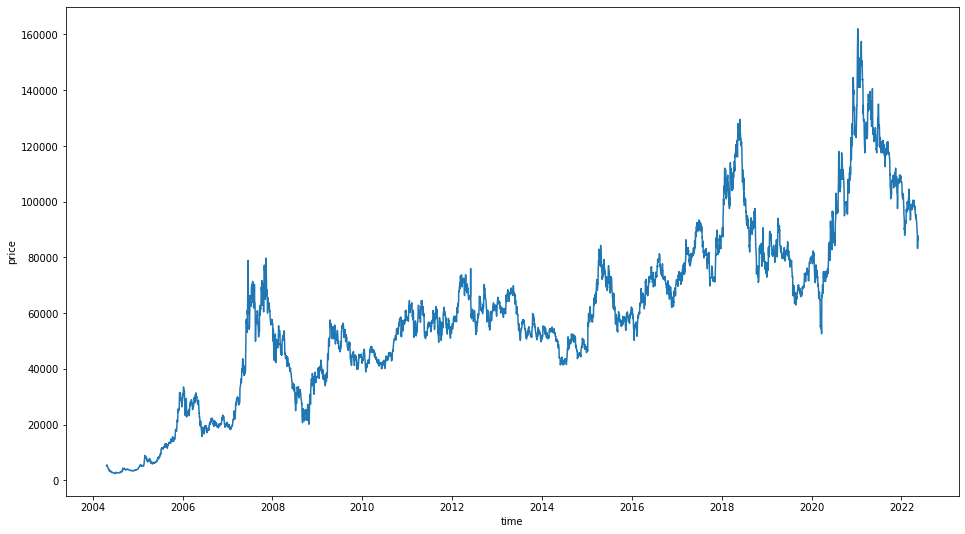

In [4]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [5]:
from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()

scaled_df = pd.DataFrame()
scaled_df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])

# 타켓 스케일링
scaler1 = MinMaxScaler()
scaled_df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))

# 스케일링 결과 확인
df


,open,high,low,close,volume
date,,,,,
2004-04-23,6076,6799,5353,5353,1415109
2004-04-26,5436,5741,5261,5398,343283
2004-04-27,5452,5482,5033,5063,299489
2004-04-28,5071,5452,4995,5444,182604
2004-04-29,5117,5436,5025,5101,109911
...,...,...,...,...,...
2022-05-11,87500,87500,85500,85800,108071
2022-05-12,84700,85300,82700,83200,104007
2022-05-13,84000,87400,83500,85800,86525


In [6]:
def make_dataset(feature, label, window_size):
  feature_list = []
  label_list = []
  
  for i in range(len(feature) - window_size) :
    feature_list.append(feature.iloc[i:i+window_size])
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

In [7]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from tensorflow.keras import optimizers

def data(batch_size, window_size):
    global mat

    BATCH_SIZE = batch_size
    WINDOW_SIZE = window_size
    TEST_SIZE = 200
    
    train = scaled_df[:-TEST_SIZE]
    test = scaled_df[-TEST_SIZE:]

    feature_cols = ['open','high','low','close','volume']
    label_cols = ['close']

    train_feature = train[feature_cols]
    train_label = train[label_cols]
    train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)
    
    test_feature = test[feature_cols]
    test_label = test[label_cols]
    test_feature , test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)

    x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.3) 
    
    return train_feature, test_feature, x_train, x_test, y_train, y_test

In [8]:
search_space = {
    'batch_size': hp.choice('bs', [30,40,50,60,70]),
    'window_size': hp.choice('ws', [20,30,50,60,80]),
    'lstm1_nodes': hp.choice('units_lsmt1', [10,20,30,40]),
    'lstm1_dropouts': hp.uniform('dos_lstm1',0,1),
    'lstm_layers': hp.choice('num_layers_lstm',[
        {
            'layers':'one', 
        },
        {
            'layers':'two',
            'lstm2_nodes': hp.choice('units_lstm2', [20,30,40,50]),
            'lstm2_dropouts': hp.uniform('dos_lstm2',0,1)  
        }
        ]),
    'dense_layers': hp.choice('num_layers_dense',[
        {
            'layers':'one'
        },
        {
            'layers':'two',
            'dense2_nodes': hp.choice('units_dense', [10,20,30,40])
        }
        ]),
    "lr": hp.uniform('lr',0,1),
    "epochs": hp.choice('epochs', [100, 150, 200, 250, 300]),
    "optimizer": hp.choice('optmz',["sgd", "rms"])
}

In [ ]:
def create_model_hypopt(params):
    print("Trying params:",params)
    batch_size = params["batch_size"]
    window_size = params["window_size"]
    train_feature, test_feature, x_train, x_test, y_train, y_test = data(batch_size, window_size)
    
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"], 
                        input_shape=(train_feature.shape[1], train_feature.shape[2]),
                        dropout=params["lstm1_dropouts"],
                        recurrent_dropout=params["lstm1_dropouts"],  
                        return_sequences=True,
                        kernel_initializer='random_uniform'))  
    
    if params["lstm_layers"]["layers"] == "two":
        lstm_model.add(LSTM(params["lstm_layers"]["lstm2_nodes"], dropout=params["lstm_layers"]["lstm2_dropouts"]))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"]["layers"] == 'two':
        lstm_model.add(Dense(params["dense_layers"]["dense2_nodes"], activation='relu'))
    
    lstm_model.add(Dense(1, activation='sigmoid'))

    lr = params["lr"]
    epochs = params["epochs"]
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=lr)
    else:
        optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3) 
    history = lstm_model.fit(x_train, y_train, 
                             epochs=epochs, 
                             verbose=2, 
                             validation_data=(x_test, y_test),
                             callbacks=[early_stop])
    val_error = np.amin(history.history['val_loss']) 
    print('Best validation error of epoch:', val_error)
    return {'loss': val_error, 'status': STATUS_OK, 'model': lstm_model} # if accuracy use '-' sign

trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10, 
    trials=trials)

Trying params:                                        
{'batch_size': 50, 'dense_layers': {'layers': 'one'}, 'epochs': 70, 'lr': 0.6701603760352657, 'lstm1_dropouts': 0.9747259587616895, 'lstm1_nodes': 100, 'lstm_layers': {'layers': 'one'}, 'optimizer': 'sgd', 'window_size': 50}
Epoch 1/70                                            
  0%|          | 0/10 [00:04<?, ?trial/s, best loss=?]

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



93/93 - 31s - loss: 0.1532 - val_loss: 0.1515         

Epoch 2/70                                            
93/93 - 16s - loss: 0.1575 - val_loss: 0.1515         

Epoch 3/70                                            
93/93 - 14s - loss: 0.1575 - val_loss: 0.1515         

Epoch 4/70                                            
93/93 - 13s - loss: 0.1575 - val_loss: 0.1515         

Best validation error of epoch:                       
0.15146903693675995                                   
Trying params:                                                                   
{'batch_size': 70, 'dense_layers': {'layers': 'one'}, 'epochs': 30, 'lr': 0.8215950469006615, 'lstm1_dropouts': 0.34806426885680153, 'lstm1_nodes': 70, 'lstm_layers': {'layers': 'two', 'lstm2_dropouts': 0.36632731450019285, 'lstm2_nodes': 50}, 'optimizer': 'sgd', 'window_size': 60}
 10%|█         | 1/10 [01:17<11:41, 77.93s/trial, best loss: 0.15146903693675995]

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/30                                                                       
93/93 - 28s - loss: 0.0058 - val_loss: 0.0014                                    

Epoch 2/30                                                                       
93/93 - 18s - loss: 0.0019 - val_loss: 0.0021                                    

Epoch 3/30                                                                       
93/93 - 19s - loss: 0.0019 - val_loss: 0.0012                                    

Epoch 4/30                                                                       
93/93 - 18s - loss: 0.0018 - val_loss: 0.0032                                    

Epoch 5/30                                                                       
93/93 - 17s - loss: 0.0019 - val_loss: 0.0016                                    

Epoch 6/30                                                                       
93/93 - 18s - loss: 0.0016 - val_loss: 0.0026                                    

Best valid

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



93/93 - 26s - loss: 0.0069 - val_loss: 0.0012                                      

Epoch 2/40                                                                         
93/93 - 14s - loss: 0.0025 - val_loss: 0.0013                                      

Epoch 3/40                                                                         
93/93 - 14s - loss: 0.0023 - val_loss: 9.6037e-04                                  

Epoch 4/40                                                                         
93/93 - 12s - loss: 0.0023 - val_loss: 0.0013                                      

Epoch 5/40                                                                         
93/93 - 13s - loss: 0.0021 - val_loss: 9.1044e-04                                  

Epoch 6/40                                                                         
93/93 - 15s - loss: 0.0022 - val_loss: 9.5723e-04                                  

Epoch 7/40                                                            

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



93/93 - 20s - loss: 0.0057 - val_loss: 8.8220e-04                                  

Epoch 2/30                                                                         
93/93 - 13s - loss: 0.0017 - val_loss: 7.1560e-04                                  

Epoch 3/30                                                                         
93/93 - 12s - loss: 0.0017 - val_loss: 7.5561e-04                                  

Epoch 4/30                                                                         
93/93 - 14s - loss: 0.0016 - val_loss: 6.9340e-04                                  

Epoch 5/30                                                                         
93/93 - 18s - loss: 0.0017 - val_loss: 6.5540e-04                                  

Epoch 6/30                                                                         
93/93 - 14s - loss: 0.0017 - val_loss: 6.6959e-04                                  

Epoch 7/30                                                            

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/30                                                                         
93/93 - 50s - loss: 0.1555 - val_loss: 0.1542                                      

Epoch 2/30                                                                         
93/93 - 23s - loss: 0.1564 - val_loss: 0.1542                                      

Epoch 3/30                                                                         
93/93 - 18s - loss: 0.1564 - val_loss: 0.1542                                      

Epoch 4/30                                                                         
93/93 - 20s - loss: 0.1564 - val_loss: 0.1542                                      

Best validation error of epoch:                                                    
0.15417319536209106                                                                
Trying params:                                                                     
{'batch_size': 60, 'dense_layers': {'dense2_nodes': 40, 'layers': 'two'}

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



93/93 - 44s - loss: 0.1530 - val_loss: 0.1595                                      

Epoch 2/70                                                                         
93/93 - 16s - loss: 0.1541 - val_loss: 0.1595                                      

Epoch 3/70                                                                         
93/93 - 23s - loss: 0.1541 - val_loss: 0.1595                                      

Epoch 4/70                                                                         
93/93 - 29s - loss: 0.1541 - val_loss: 0.1595                                      

Best validation error of epoch:                                                    
0.15954698622226715                                                                
Trying params:                                                                     
{'batch_size': 30, 'dense_layers': {'layers': 'one'}, 'epochs': 60, 'lr': 0.8797770890494199, 'lstm1_dropouts': 0.24458198826780475, 'lstm1_nodes': 130, 'ls

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/60                                                                         
93/93 - 66s - loss: 0.0061 - val_loss: 9.1839e-04                                  

Epoch 2/60                                                                         
93/93 - 34s - loss: 0.0018 - val_loss: 0.0017                                      

Epoch 3/60                                                                         
93/93 - 31s - loss: 0.0016 - val_loss: 0.0011                                      

Epoch 4/60                                                                         
93/93 - 31s - loss: 0.0016 - val_loss: 6.7564e-04                                  

Epoch 5/60                                                                         
93/93 - 36s - loss: 0.0015 - val_loss: 0.0035                                      

Epoch 6/60                                                                         
93/93 - 29s - loss: 0.0015 - val_loss: 0.0016                          

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/70                                                                         
93/93 - 32s - loss: 0.0551 - val_loss: 0.0617                                      

Epoch 2/70                                                                         
93/93 - 17s - loss: 0.0457 - val_loss: 0.0410                                      

Epoch 3/70                                                                         
93/93 - 17s - loss: 0.0470 - val_loss: 0.0506                                      

Epoch 4/70                                                                         
93/93 - 17s - loss: 0.0481 - val_loss: 0.0398                                      

Epoch 5/70                                                                         
93/93 - 24s - loss: 0.0490 - val_loss: 0.0733                                      

Epoch 6/70                                                                         
93/93 - 20s - loss: 0.0479 - val_loss: 0.0447                          

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



Epoch 1/60                                                                         
93/93 - 46s - loss: 0.1539 - val_loss: 0.1586                                      

Epoch 2/60                                                                         
93/93 - 29s - loss: 0.1550 - val_loss: 0.1586                                      

Epoch 3/60                                                                         
93/93 - 20s - loss: 0.1550 - val_loss: 0.1586                                      

Epoch 4/60                                                                         
93/93 - 21s - loss: 0.1550 - val_loss: 0.1586                                      

Best validation error of epoch:                                                    
0.15864133834838867                                                                
Trying params:                                                                     
{'batch_size': 70, 'dense_layers': {'dense2_nodes': 20, 'layers': 'two'}

c:\anaconda3\envs\py64\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



93/93 - 42s - loss: 0.1525 - val_loss: 0.1583                                      

Epoch 2/60                                                                         
93/93 - 14s - loss: 0.1536 - val_loss: 0.1583                                      

Epoch 3/60                                                                         
93/93 - 13s - loss: 0.1536 - val_loss: 0.1583                                      

Epoch 4/60                                                                         
93/93 - 13s - loss: 0.1536 - val_loss: 0.1583                                      

Best validation error of epoch:                                                    
0.15827545523643494                                                                
100%|██████████| 10/10 [23:06<00:00, 138.62s/trial, best loss: 0.000655401439871639]


In [ ]:
best

{'bs': 0,
 'dos_lstm1': 0.3101220683278205,
 'epochs': 0,
 'lr': 0.8697479458827077,
 'num_layers_dense': 1,
 'num_layers_lstm': 0,
 'optmz': 0,
 'units_dense': 2,
 'units_lsmt1': 2,
 'ws': 0}